In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import argparse
import sys
import os

In [10]:
KAGGLE_MODULE_PATH = '/kaggle/input/dl-assignment-again/pytorch/default/1'
if KAGGLE_MODULE_PATH not in sys.path:
    sys.path.append(KAGGLE_MODULE_PATH)
from model import CaltechNetwork

In [23]:
img1_path = '/kaggle/input/dl-assignment-again/pytorch/default/1/caltech-101/caltech-101/Motorbikes/image_0004.jpg'
# img2_path = '/kaggle/input/dl-assignment-again/pytorch/default/1/caltech-101/caltech-101/airplanes/image_0007.jpg'
img2_path = '/kaggle/input/dl-assignment-again/pytorch/default/1/caltech-101/caltech-101/Motorbikes/image_0022.jpg'

In [24]:
model_weights_path = '/kaggle/input/training-final-dl-ass-02/weights/best_model.pth'

In [25]:
threshold_value = 0.5 # The threshold used during training for similarity decision

# --- 4. Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 5. Load Model ---
print(f"Attempting to load model weights from: {model_weights_path}")

Using device: cpu
Attempting to load model weights from: /kaggle/input/training-final-dl-ass-02/weights/best_model.pth


In [26]:
if not os.path.exists(model_weights_path):
    print(f"ERROR: Model weights not found at '{model_weights_path}'.")
    print("Please verify the path to 'best_model.pth'. It should be an input from your training kernel's output.")
    # Exit or raise error if model not found
    # For a notebook, we can just print and let it fail if model is None
    model = None
else:
    try:
        # Assuming CaltechNetwork uses default embedding_size=128 if not specified in its __init__
        model = CaltechNetwork().to(device)
        model.load_state_dict(torch.load(model_weights_path, map_location=device))
        model.eval() # Set model to evaluation mode
        print(f"Model loaded successfully from {model_weights_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        model = None # Ensure model is None if loading failed

Model loaded successfully from /kaggle/input/training-final-dl-ass-02/weights/best_model.pth


/tmp/ipykernel_31/3612694678.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_location=device))


In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Crucial to match training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
def evaluate_notebook_pair(model_instance, image_path1, image_path2, image_transform, current_device):
    if model_instance is None:
        print("Model is not loaded. Cannot evaluate.")
        return None, None, None
    try:
        pil_img1 = Image.open(image_path1).convert('RGB')
        pil_img2 = Image.open(image_path2).convert('RGB')
    except FileNotFoundError as e:
        print(f"Error: Could not open an image file. {e}")
        return None, None, None

    img1_tensor = image_transform(pil_img1).unsqueeze(0).to(current_device)
    img2_tensor = image_transform(pil_img2).unsqueeze(0).to(current_device)

    model_instance.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        emb1, emb2 = model_instance(img1_tensor, img2_tensor)

    distance = torch.nn.functional.pairwise_distance(emb1, emb2).item()
    return distance, pil_img1, pil_img2


Calculated Distance between images: 0.0402
Decision (Distance < 0.5): Similar


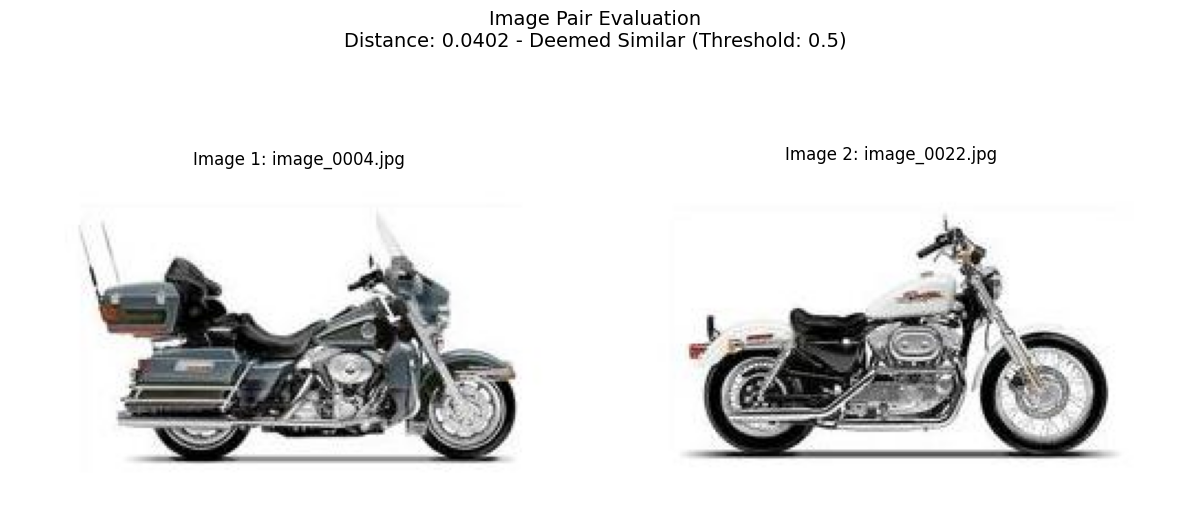

In [29]:
if model: # Proceed only if the model was loaded successfully
    distance, pil_img1, pil_img2 = evaluate_notebook_pair(model, img1_path, img2_path, transform, device)

    if distance is not None: # Check if image loading and evaluation were successful
        print(f'\nCalculated Distance between images: {distance:.4f}')

        # Determine similarity based on the threshold
        is_similar = distance < threshold_value
        similarity_decision = "Similar" if is_similar else "Dissimilar"
        print(f"Decision (Distance < {threshold_value}): {similarity_decision}")

        # Plotting
        if pil_img1 and pil_img2:
            fig, axs = plt.subplots(1, 2, figsize=(12, 6)) # Adjusted figure size

            axs[0].imshow(pil_img1)
            axs[0].set_title(f"Image 1: {os.path.basename(img1_path)}")
            axs[0].axis('off')

            axs[1].imshow(pil_img2)
            axs[1].set_title(f"Image 2: {os.path.basename(img2_path)}")
            axs[1].axis('off')

            fig.suptitle(f'Image Pair Evaluation\nDistance: {distance:.4f} - Deemed {similarity_decision} (Threshold: {threshold_value})', fontsize=14)
            plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout for suptitle
            plt.show()
        else:
            print("Could not display images due to an earlier loading error.")
    else:
        print("Evaluation could not be performed due to an error loading images.")
else:
    print("Skipping evaluation as the model was not loaded successfully.")